In [1]:
#dataframes
import pandas as pd
import h5py

import sys
sys.path.append('../../')
import odor_statistics_lib as osm

# user defined functions

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
import scipy 
import scipy.stats as st
from scipy.stats import kurtosis

#plots
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib
from figurefirst import FigureLayout,mpl_functions
import figurefirst
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
import figurefirst as fifi
from IPython.display import display,SVG

import networkx as nx
import community.community_louvain as community_louvain # pip install community

#misc
import cairosvg
import time
np.set_printoptions(suppress=True)
import fly_plot_lib.plot as fpl
# matplotlib.rcParams['font.family'] = [ 'sans-serif']
FS=7

In [2]:
dir = '~/DataAnalysis/data/Sprints/HighRes/LouvainAnalysis/'
dataframe=pd.read_hdf(dir+'AllPredictions6V.h5')

In [3]:
# Helper function
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = nx.to_networkx_graph(assignment_matrix, create_using=nx.Graph())  
    louvain_community_dict = community_louvain.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.items():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]
    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
    return G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix

X=[dataframe.mc_min, dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
   dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
   dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
   dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
   dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]

REMOVE_Y_CORR = False
y=dataframe.distance


corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(corr_mat)

In [4]:
n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label = sorted(dicts.items(), key=lambda pair: nodes_louvain_ordered.index(pair[0]))

new_list = []
for i in range(len(new_list_label)):
    new_list.append(new_list_label[i][1])
new_list.insert(0, 0)    

In [5]:
print(new_list)

[0, 'mc_min', 'wd_min', 'st_min', 'mc_max', 'mc_std_dev', 'st_max', 'st_std_dev', 'mc_mean', 'st_mean', 'mc_k', 'wd_k', 'ma_k', 'st_k', 'wf_min', 'wf_max', 'wf_mean', 'wf_std_dev', 'wf_k', 'wd_max', 'wd_mean', 'wd_std_dev', 'ma_max', 'ma_mean', 'ma_std_dev', 'ma_min']


In [6]:
## Create latex labels for final plots - manually from new list
label6v=['$min(WC)$','$min(WD)$','$min(WSD)$', '$max(WC)$','$\sigma(WC)$',
         '$max(WSD)$','$\sigma(WSD)$','$\mu(WC)$','$\mu(WSD)$', '$WC_k$',
         '$WD_k$','$WMA_k$','$WSD_k$','$min(WF)$', '$max(wf)$',
         '$\mu(WF)$','$\sigma(WF)$','$WF_k$','$max(WD)$', '$\mu(WD)$',
         '$\sigma(WD)$','$max(WMA)$','$\mu(WMA)$', '$\sigma(WSD)$','$min(WMA)$']

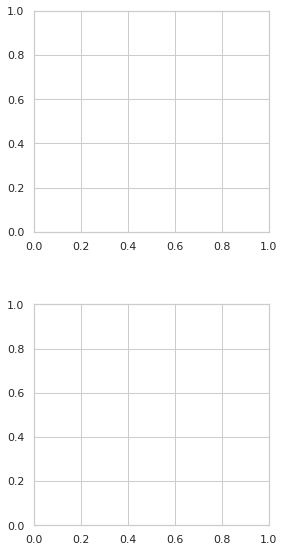

In [7]:
layout = fifi.svg_to_axes.FigureLayout('../../../../Figure/louvainExtras.svg',
                                           autogenlayers=True, make_mplfigures=True, hide_layers=[])

### @ 6 volts

In [8]:
ax=layout.axes[('fig1','ax1')]
ax.imshow(adjacency_matrix,cmap='bone_r',  aspect='auto',rasterized=True)


ax.grid(False)
# ax.set_title('')louvain

ax.set_rasterization_zorder(-20)

marker = np.arange(0,25,1)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=marker.tolist(),
                            xticks=marker.tolist(),
                            linewidth=0.5)
ax.set_xticklabels(label6v, rotation=90)
ax.set_yticklabels(label6v, rotation=0)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/louvainExtras.svg')

### @ 8 volts

In [9]:
dir = '~/DataAnalysis/data/Sprints/HighRes/LouvainAnalysis/'
dataframe=pd.read_hdf(dir+'AllPredictions8V.h5')

# Helper function
def calculate_louvain_communities(assignment_matrix, node_order=None):
    # Calculate louvain communities
    G = nx.to_networkx_graph(assignment_matrix, create_using=nx.Graph())  
    louvain_community_dict = community_louvain.best_partition(G)
    # Convert community assignmet dict into list of communities
    louvain_comms = {}
    for node_index, comm_id in louvain_community_dict.items():
        if comm_id in louvain_comms.keys():
            louvain_comms[comm_id].append(node_index)
        else:
            louvain_comms.setdefault(comm_id, [node_index])
    nodes_louvain_ordered = [node for comm in louvain_comms.values() for node in comm]
    # reorder original matrix according to node order
    adjacency_matrix = np.zeros_like(assignment_matrix)
    for i in range(assignment_matrix.shape[0]):
        for j in range(assignment_matrix.shape[0]):
            r = nodes_louvain_ordered.index(i)
            c = nodes_louvain_ordered.index(j)
            adjacency_matrix[r,c] = assignment_matrix[i,j] 
    return G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix

X=[dataframe.mc_min, dataframe.mc_max, dataframe.mc_mean, dataframe.mc_std_dev, dataframe.mc_k,
   dataframe.wf_min, dataframe.wf_max, dataframe.wf_mean, dataframe.wf_std_dev, dataframe.wf_k,
   dataframe.wd_min, dataframe.wd_max, dataframe.wd_mean, dataframe.wd_std_dev, dataframe.wd_k,
   dataframe.ma_min, dataframe.ma_max, dataframe.ma_mean, dataframe.ma_std_dev, dataframe.ma_k,
   dataframe.st_min, dataframe.st_max, dataframe.st_mean, dataframe.st_std_dev, dataframe.st_k]

REMOVE_Y_CORR = False
y=dataframe.distance


corr_mat = np.zeros([len(X), len(X)])
for i in range(len(X)):
    for j in range(len(X)):
        
        if not REMOVE_Y_CORR:
            result = scipy.stats.linregress(X[i], X[j])
        else:
            result_iy = scipy.stats.linregress(y, X[i])
            resid_i = X[i] - (y*result_iy.slope + result_iy.intercept)

            result_jy = scipy.stats.linregress(y, X[j])
            resid_j = X[j] - (y*result_jy.slope + result_jy.intercept)
            
            result = scipy.stats.linregress(resid_i, resid_j)
            
        corr_mat[i,j] = result.rvalue**2
        
G, louvain_community_dict, nodes_louvain_ordered, adjacency_matrix = calculate_louvain_communities(corr_mat)


n = []
for i in range(len(X)):
    n.append(X[i].name)

dicts = {}
keys = range(len(X))
values = n
for i in keys:
        dicts[i] = values[i]
        
new_list_label = sorted(dicts.items(), key=lambda pair: nodes_louvain_ordered.index(pair[0]))

new_list = []
for i in range(len(new_list_label)):
    new_list.append(new_list_label[i][1])
new_list.insert(0, 0)    

print(new_list)

[0, 'mc_min', 'mc_std_dev', 'wd_min', 'st_min', 'mc_max', 'mc_mean', 'wd_mean', 'mc_k', 'st_k', 'wf_min', 'wd_max', 'wd_std_dev', 'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev', 'wf_max', 'wf_mean', 'wf_std_dev', 'wf_k', 'wd_k', 'ma_k', 'st_max', 'st_mean', 'st_std_dev']


In [10]:
## Create latex labels for final plots - manually from new list
label8v=['$min(WC)$','$\sigma(WC)$','$min(WD)$', '$min(WSD)$',
      '$max(WC)$','$max(WSD)$','$\sigma(WSD)$','$\mu(WC)$', '$\mu(WD)$',
      '$\mu(WSD)$','$WC_k$','$WSD_k$','$min(WF)$', '$max(WF)$',
      '$\mu(WF)$','$\sigma(WF)$','$WF_k$','$max(WD)$', '$\sigma(WD)$',
      '$max(WMA)$','$\sigma(WMA)$','$WD_k$','$WMA_k$', '$min(WMA)$','$\mu(WMA)$']

In [11]:
ax=layout.axes[('fig1','ax2')]
ax.imshow(adjacency_matrix,cmap='bone_r',  aspect='auto',rasterized=True)


ax.grid(False)
# ax.set_title('')louvain

ax.set_rasterization_zorder(-20)

marker = np.arange(0,25,1)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=marker.tolist(),
                            xticks=marker.tolist(),
                            linewidth=0.5)
ax.set_xticklabels(label8v, rotation=90)
ax.set_yticklabels(label8v, rotation=0)

figurefirst.mpl_functions.set_fontsize(ax, FS)
layout.append_figure_to_layer(layout.figures['fig1'], 'fig1', cleartarget=True)
layout.write_svg('../../../../Figure/louvainExtras.svg')